# Q1

In [1]:
import pyspark
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
import os
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tensor
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torch
from torch.utils.data import Dataset, DataLoader



In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]


from pyspark.sql.functions import when

from pyspark.sql.functions import when, col, trim, upper

class OutcomeCreater(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        # Clean the 'class' column: trim whitespace and standardize to uppercase
        dataset = dataset.withColumn('class', upper(trim(col('class'))))

        # Define the mapping logic to categorize into the five attack categories
        output_df = dataset.withColumn(
            'outcome',
            when(col('class') == 'NORMAL', 0.0)  # Normal traffic
            .when(col('class').isin('NEPTUNE', 'SMURF', 'TEARDROP', 'POD', 'LAND', 'BACK', 'TFTP', 'TEARDROP'), 1.0)  # DOS attacks
            .when(col('class').isin('WAREZCLIENT', 'SATAN', 'GUESS_PASSWD', 'WAREZMASTER', 'FTPSWRITE'), 2.0)  # R2L attacks
            .when(col('class').isin('BUFFER_OVERFLOW', 'ROOTKIT', 'PERL'), 3.0)  # U2R attacks
            .when(col('class').isin('NMAP', 'IPSWEEP', 'PORTSWEEP', 'MULITHOP'), 4.0)  # Probing attacks
            .otherwise(5.0)  # Any unknown category will be classified as 'Other'
        )

        # Drop the original 'class' and 'difficulty' columns after transformation
        output_df = output_df.drop('class').drop('difficulty')

        return output_df



class FeatureTypeCaster(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df

class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop=None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        return dataset.drop(*self.columns_to_drop)

# Column groups
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
continuous_cols = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
                   'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations',
                   'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count',
                   'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
                   'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
                   'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                   'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                   'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                   'dst_host_srv_rerror_rate']
nominal_cols = ['protocol_type', 'service', 'flag']

def get_preprocess_pipeline():
    # Casting binary and continuous columns
    stage_typecaster = FeatureTypeCaster()

    # Indexing and one-hot encoding nominal columns
    nominal_id_cols = [f"{x}_index" for x in nominal_cols]
    nominal_onehot_cols = [f"{x}_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Assembling all feature columns into a vector
    feature_cols = continuous_cols + binary_cols + nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate", "srv_serror_rate", "dst_host_srv_serror_rate",
                                "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
    feature_cols = [col for col in feature_cols if col not in corelated_cols_to_remove]

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Scaling
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

    # Mapping class labels and dropping extra columns
    stage_outcome = OutcomeCreater()
    stage_column_dropper = ColumnDropper(columns_to_drop=nominal_cols + nominal_id_cols + nominal_onehot_cols +
                                         binary_cols + continuous_cols + ['vectorized_features'])

    # Create and return pipeline
    pipeline = Pipeline(stages=[
        stage_typecaster,
        stage_nominal_indexer,
        stage_nominal_onehot_encoder,
        stage_vector_assembler,
        stage_scaler,
        stage_outcome,
        stage_column_dropper
    ])

    return pipeline


In [4]:
# if you installed Spark on windows,
# you may need findspark and need to initialize it prior to being able to use pyspark
# Also, you may need to initialize SparkContext yourself.
# Uncomment the following lines if you are using Windows!
#findspark.init()
#findspark.find()

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('/content/NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('/content/NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)


In [5]:
# Apply preprocessing pipeline to both DataFrames
pipeline_model = get_preprocess_pipeline().fit(nslkdd_raw)
train_df = pipeline_model.transform(nslkdd_raw)
test_df = pipeline_model.transform(nslkdd_test_raw)

In [6]:
# Replacing NaNs with 0 bc i kept getting errors

train_df = train_df.na.fill(0, subset=['features', 'outcome'])
test_df = test_df.na.fill(0, subset=['features', 'outcome'])

In [7]:
print("train:", train_df)
print("test", test_df)

train: DataFrame[features: vector, outcome: double]
test DataFrame[features: vector, outcome: double]


In [8]:
# Split Pyspark df in half
train_df_spark, validate_df_spark = test_df.randomSplit([0.5, 0.5], seed=42)

# Converting to pandas df
nslkdd_df_train_pandas = train_df_spark.toPandas()
nslkdd_df_validate_pandas = validate_df_spark.toPandas()
nslkdd_df_test_pandas = test_df.toPandas()

In [9]:
# Converting pandas df to torch tensor (lecture 13)

x_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['outcome'].values.tolist(),np.int64))

x_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['outcome'].values.tolist(),np.int64))

x_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['outcome'].values.tolist(),np.int64))

In [10]:
# Converting tensors to datasets

class MyDataset():
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

train_dataset = MyDataset(x_train, y_train)
validate_dataset = MyDataset(x_validate, y_validate)
test_dataset = MyDataset(x_test, y_test)

# Q2

In [11]:
# Define the model class
class MyMultiLayerPerception(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyMultiLayerPerception, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
input_dim = x_train.shape[1]
output_dim = len(torch.unique(y_train))
print(MyMultiLayerPerception(input_dim, output_dim))

MyMultiLayerPerception(
  (fc1): Linear(in_features=113, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


# Q3

x_train: tensor([[2.0733e-02, 5.5465e-04, 9.0663e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.6790e-04, 6.7799e-05, 9.6512e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.8189e-01, 5.2144e-04, 1.3663e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
y_train: tensor([5, 5, 5,  ..., 4, 4, 4])
x_validate: tensor([[7.0647e-02, 4.9793e-04, 1.3143e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.2916e-02, 8.5855e-05, 6.7640e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0869e-01, 2.7068e-04, 9.0484e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.00

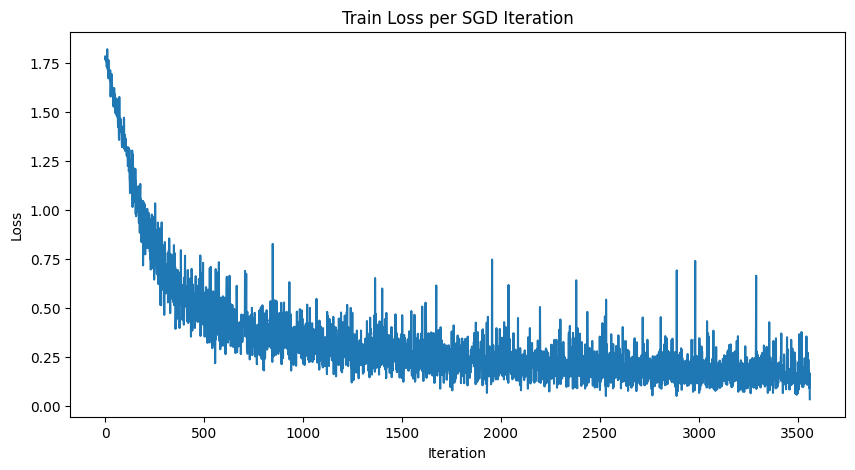

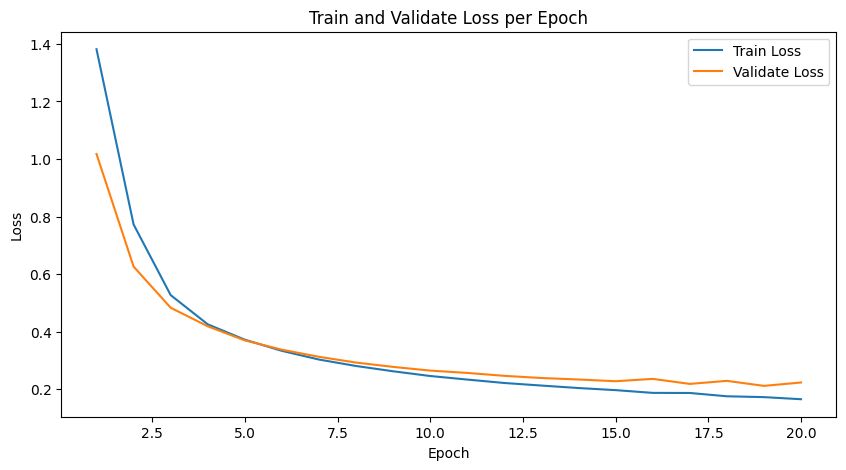

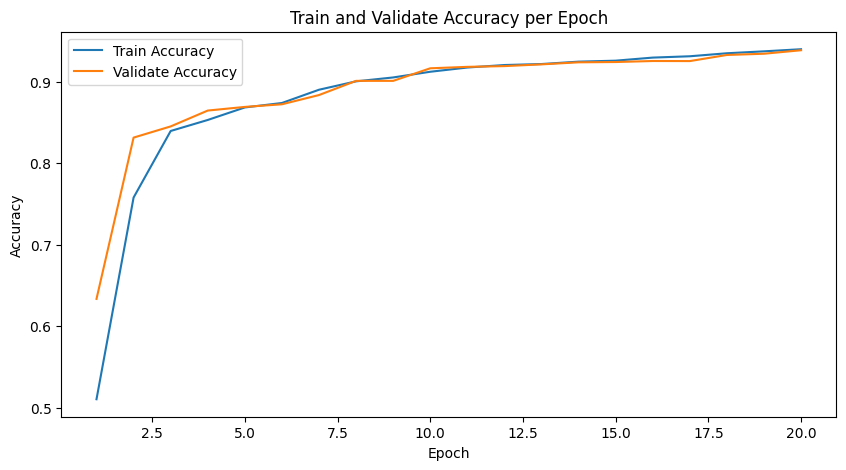

In [13]:
# Create data loaders
def create_dataloaders(train_dataset, validate_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validate_loader


################ Training for one epoch ##################
# Training function for one epoch
def train_one_epoch(model, dataloader, optimizer, loss_fun, batch_losses):
    model.train()
    batch_accuracy = []
    for x_batch, y_batch in dataloader:
        prediction = model(x_batch)
        loss = loss_fun(prediction, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        prediction_label = torch.argmax(prediction, dim=1).detach().cpu().numpy()
        batch_accuracy.append(np.mean(prediction_label == y_batch.cpu().numpy()))
    return np.mean(batch_accuracy)

# Validation function for one epoch
def validate_one_epoch(model, dataloader, loss_fun, epoch_losses, epoch_accuracies):
    model.eval()
    validate_batch_accuracy = []
    validate_batch_loss = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            prediction = model(x_batch)
            loss = loss_fun(prediction, y_batch)
            validate_batch_loss.append(loss.item())
            prediction_label = torch.argmax(prediction, dim=1).detach().cpu().numpy()
            validate_batch_accuracy.append(np.mean(prediction_label == y_batch.cpu().numpy()))

    epoch_losses.append(np.mean(validate_batch_loss))
    epoch_accuracies.append(np.mean(validate_batch_accuracy))



################ Train model over multiple epochs ##################
# Main training loop that trains and validates the model
def train_model(model, train_loader, validate_loader, optimizer, loss_fun, N_epochs):
    losses, validate_losses = [], []
    accuracies, validate_accuracies = [], []
    all_batch_losses = []  # Store train losses for every batch
    current_best_accuracy = 0.0

    for epoch in range(N_epochs):
        epoch_losses = []
        epoch_accuracies = []

        # Train for one epoch
        train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fun, all_batch_losses)

        # Validate for one epoch
        validate_one_epoch(model, validate_loader, loss_fun, epoch_losses, epoch_accuracies)

        # Store the losses and accuracies for this epoch
        losses.append(np.mean(all_batch_losses[-len(train_loader):]))
        accuracies.append(train_accuracy)
        validate_losses.append(np.mean(epoch_losses))
        validate_accuracies.append(np.mean(epoch_accuracies))

        # Print progress
        print(f"Epoch {epoch+1}/{N_epochs}, Train Loss: {losses[-1]:.4f}, Validate Loss: {validate_losses[-1]:.4f}")
        print(f"Train Accuracy: {accuracies[-1]:.4f}, Validate Accuracy: {validate_accuracies[-1]:.4f}")

        # Save the best model so far
        if validate_accuracies[-1] > current_best_accuracy:
            print("New best model found. Saving...")
            torch.save(model.state_dict(), 'current_best_model.pth')
            current_best_accuracy = validate_accuracies[-1]

    return losses, validate_losses, accuracies, validate_accuracies, all_batch_losses



################ Plotting ##################
# Plot metrics after training
def plot_metrics(N_epochs, losses, validate_losses, accuracies, validate_accuracies, all_batch_losses):
    # Train loss per SGD iteration
    total_iterations = len(all_batch_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, total_iterations + 1), all_batch_losses, label="Train Loss per Batch")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Train Loss per SGD Iteration")
    plt.show()

    # Train and Validate Losses p/ Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, N_epochs + 1), losses, label="Train Loss")
    plt.plot(range(1, N_epochs + 1), validate_losses, label="Validate Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validate Loss per Epoch")
    plt.legend()
    plt.show()

    # Train and Validate Accuracy p/ Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, N_epochs + 1), accuracies, label="Train Accuracy")
    plt.plot(range(1, N_epochs + 1), validate_accuracies, label="Validate Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validate Accuracy per Epoch")
    plt.legend()
    plt.show()

################ Handling Tensors ##################
class TensorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = TensorDataset(x_train, y_train)
validate_dataset = TensorDataset(x_validate, y_validate)
test_dataset = TensorDataset(x_test, y_test)
print("x_train:", x_train)
print("y_train:", y_train)
print("x_validate:", x_validate)
print("y_validate:", y_validate)

def main(input_dim, output_dim, lr=0.01, batch_size=64, N_epochs=20):
    model = MyMultiLayerPerception(input_dim, output_dim)
    train_loader, validate_loader = create_dataloaders(train_dataset, validate_dataset, batch_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fun = nn.CrossEntropyLoss()

    # Train model
    losses, validate_losses, accuracies, validate_accuracies, all_batch_losses = train_model(model, train_loader, validate_loader, optimizer, loss_fun, N_epochs)

    # Plot results
    plot_metrics(N_epochs, losses, validate_losses, accuracies, validate_accuracies, all_batch_losses)


################ Plotting Final ##################
def plot_metrics(N_epochs, losses, validate_losses, accuracies, validate_accuracies, all_batch_losses):
    # Train loss p/ SGD iteration
    total_iterations = len(all_batch_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, total_iterations + 1), all_batch_losses, label="Train Loss per Batch")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Train Loss per SGD Iteration")
    plt.show()

    # Train and Validate Losses p/ Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, N_epochs + 1), losses, label="Train Loss")
    plt.plot(range(1, N_epochs + 1), validate_losses, label="Validate Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validate Loss per Epoch")
    plt.legend()
    plt.show()

    # Train and Validate Accuracy p/ Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, N_epochs + 1), accuracies, label="Train Accuracy")
    plt.plot(range(1, N_epochs + 1), validate_accuracies, label="Validate Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validate Accuracy per Epoch")
    plt.legend()
    plt.show()

input_dim = x_train.shape[1]
output_dim = len(torch.unique(y_train))
main(input_dim, output_dim)


# Q4

Epoch 1/20, Train Loss: 1.5895, Validate Loss: 1.3748
Train Accuracy: 0.4747, Validate Accuracy: 0.4992
New best model found. Saving...
Epoch 2/20, Train Loss: 1.1589, Validate Loss: 0.9984
Train Accuracy: 0.5920, Validate Accuracy: 0.7117
New best model found. Saving...
Epoch 3/20, Train Loss: 0.8586, Validate Loss: 0.7704
Train Accuracy: 0.7398, Validate Accuracy: 0.7623
New best model found. Saving...
Epoch 4/20, Train Loss: 0.6799, Validate Loss: 0.6316
Train Accuracy: 0.7871, Validate Accuracy: 0.8252
New best model found. Saving...
Epoch 5/20, Train Loss: 0.5657, Validate Loss: 0.5411
Train Accuracy: 0.8319, Validate Accuracy: 0.8352
New best model found. Saving...
Epoch 6/20, Train Loss: 0.4910, Validate Loss: 0.4813
Train Accuracy: 0.8396, Validate Accuracy: 0.8406
New best model found. Saving...
Epoch 7/20, Train Loss: 0.4409, Validate Loss: 0.4408
Train Accuracy: 0.8474, Validate Accuracy: 0.8478
New best model found. Saving...
Epoch 8/20, Train Loss: 0.4046, Validate Loss: 0

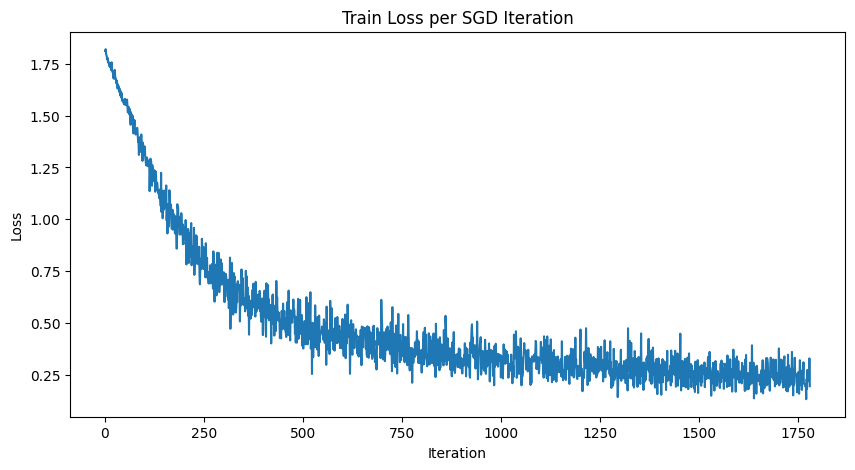

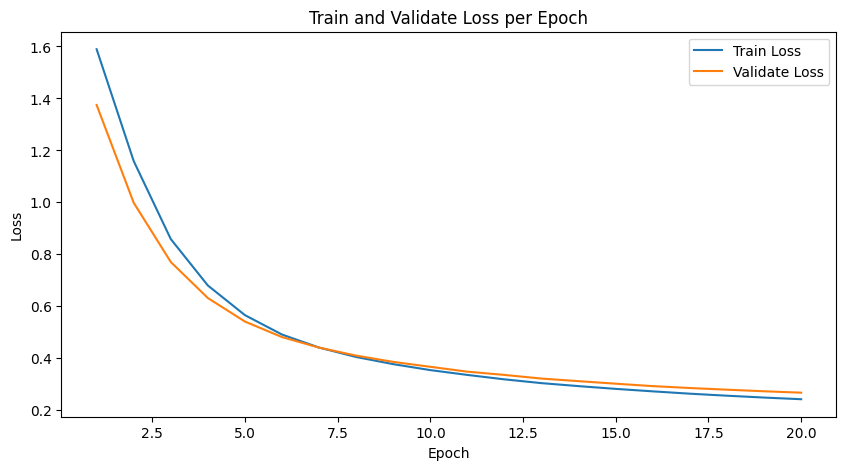

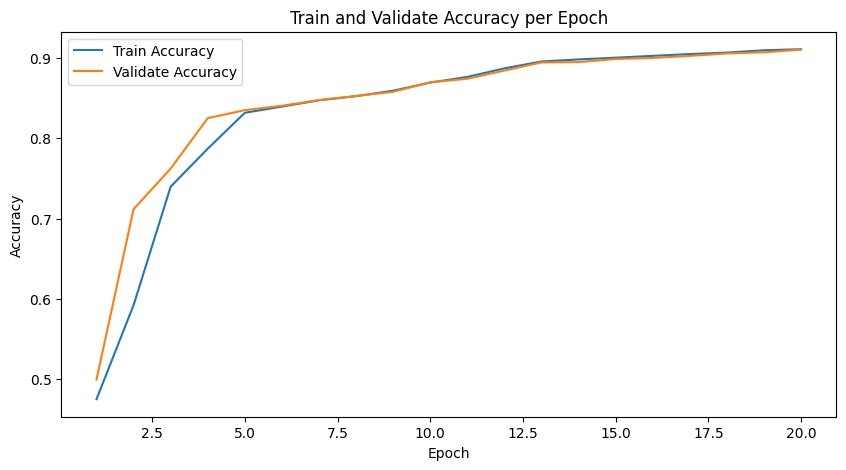

In [14]:
# Set 1

main(input_dim, output_dim, lr=0.01, batch_size=128, N_epochs=20)

Epoch 1/50, Train Loss: 0.7529, Validate Loss: 0.3929
Train Accuracy: 0.7628, Validate Accuracy: 0.8850
New best model found. Saving...
Epoch 2/50, Train Loss: 0.3111, Validate Loss: 0.2788
Train Accuracy: 0.8950, Validate Accuracy: 0.9099
New best model found. Saving...
Epoch 3/50, Train Loss: 0.2307, Validate Loss: 0.2330
Train Accuracy: 0.9182, Validate Accuracy: 0.9242
New best model found. Saving...
Epoch 4/50, Train Loss: 0.1984, Validate Loss: 0.2284
Train Accuracy: 0.9280, Validate Accuracy: 0.9216
Epoch 5/50, Train Loss: 0.1779, Validate Loss: 0.2428
Train Accuracy: 0.9370, Validate Accuracy: 0.9239
Epoch 6/50, Train Loss: 0.1612, Validate Loss: 0.1990
Train Accuracy: 0.9439, Validate Accuracy: 0.9484
New best model found. Saving...
Epoch 7/50, Train Loss: 0.1467, Validate Loss: 0.1838
Train Accuracy: 0.9474, Validate Accuracy: 0.9521
New best model found. Saving...
Epoch 8/50, Train Loss: 0.1351, Validate Loss: 0.1920
Train Accuracy: 0.9519, Validate Accuracy: 0.9388
Epoch 9/

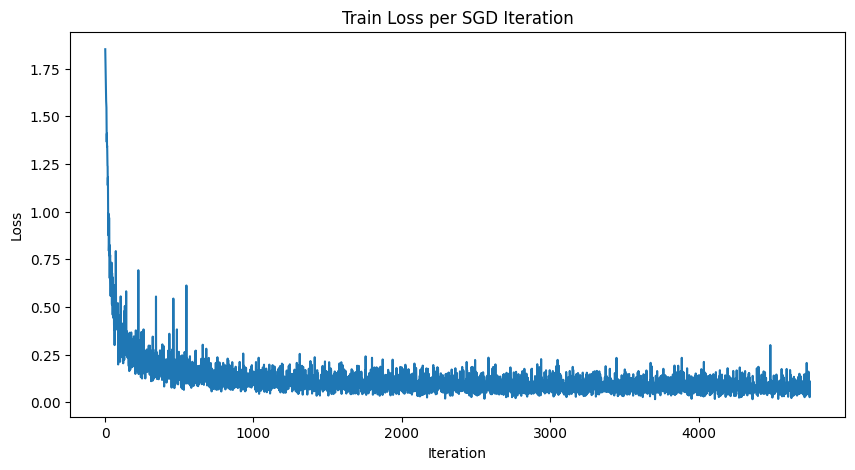

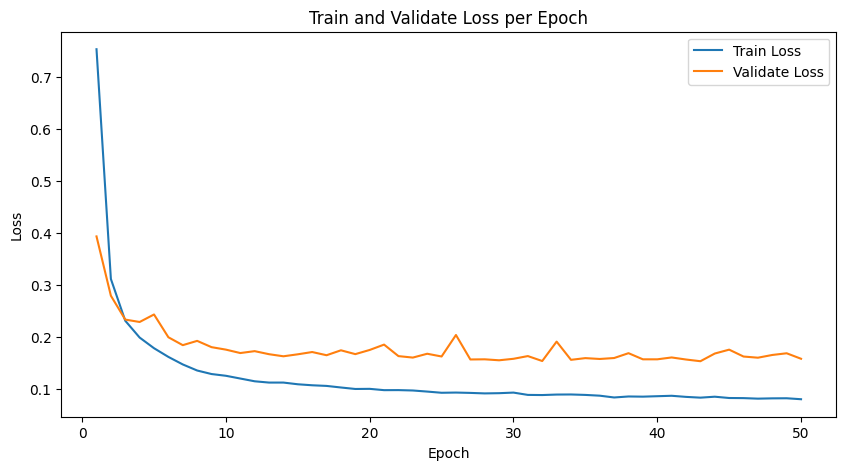

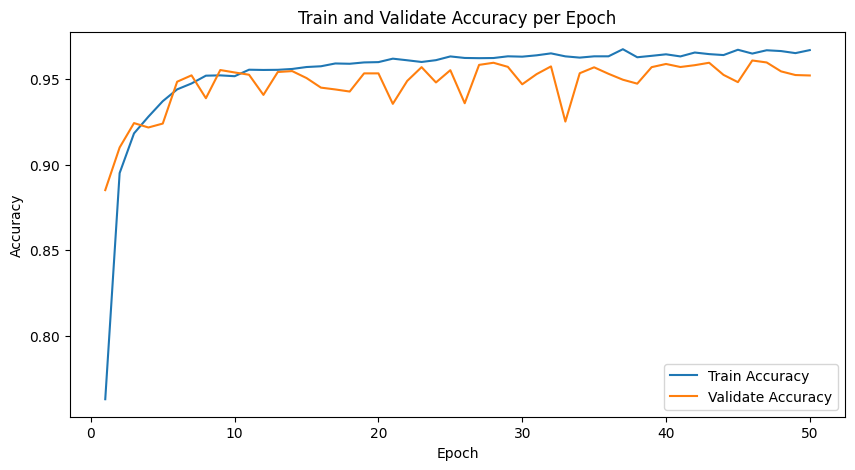

In [15]:
# Set 2

input_dim = x_train.shape[1]
output_dim = len(torch.unique(y_train))

main(input_dim, output_dim, lr=0.1, batch_size=120, N_epochs=50)

Epoch 1/50, Train Loss: 1.7918, Validate Loss: 1.7895
Train Accuracy: 0.2488, Validate Accuracy: 0.3234
New best model found. Saving...
Epoch 2/50, Train Loss: 1.7830, Validate Loss: 1.7811
Train Accuracy: 0.4108, Validate Accuracy: 0.4612
New best model found. Saving...
Epoch 3/50, Train Loss: 1.7746, Validate Loss: 1.7729
Train Accuracy: 0.4797, Validate Accuracy: 0.4718
New best model found. Saving...
Epoch 4/50, Train Loss: 1.7664, Validate Loss: 1.7648
Train Accuracy: 0.4827, Validate Accuracy: 0.4738
New best model found. Saving...
Epoch 5/50, Train Loss: 1.7582, Validate Loss: 1.7568
Train Accuracy: 0.4848, Validate Accuracy: 0.4780
New best model found. Saving...
Epoch 6/50, Train Loss: 1.7500, Validate Loss: 1.7489
Train Accuracy: 0.4885, Validate Accuracy: 0.4807
New best model found. Saving...
Epoch 7/50, Train Loss: 1.7421, Validate Loss: 1.7411
Train Accuracy: 0.4895, Validate Accuracy: 0.4810
New best model found. Saving...
Epoch 8/50, Train Loss: 1.7344, Validate Loss: 1

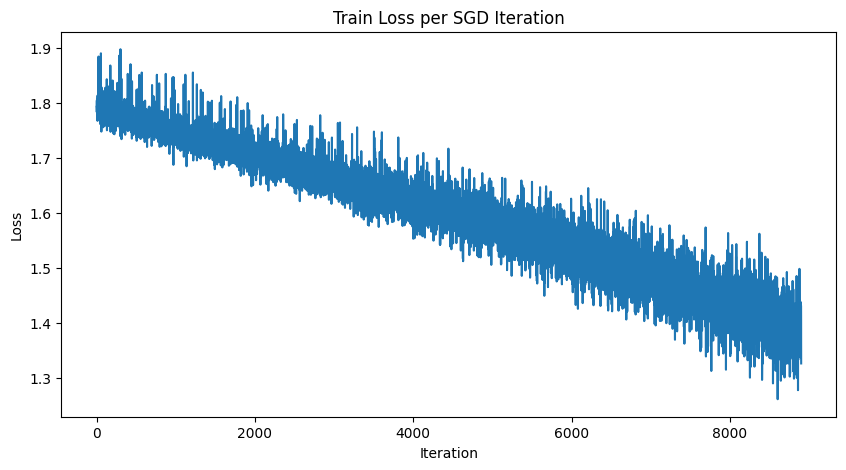

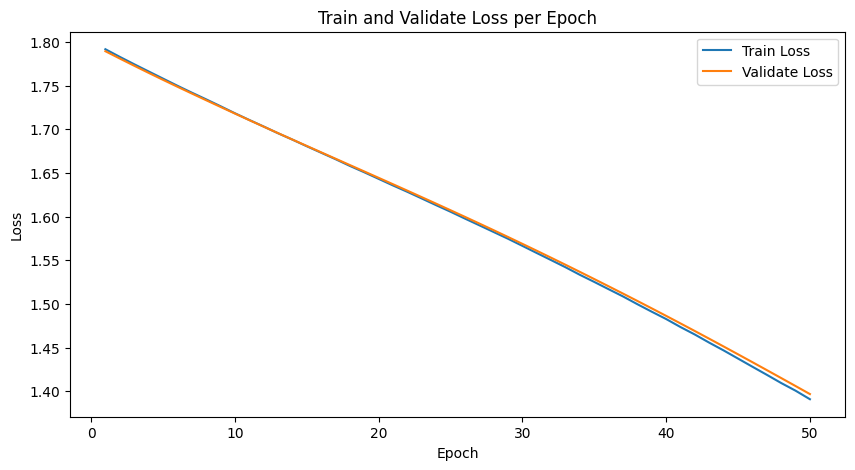

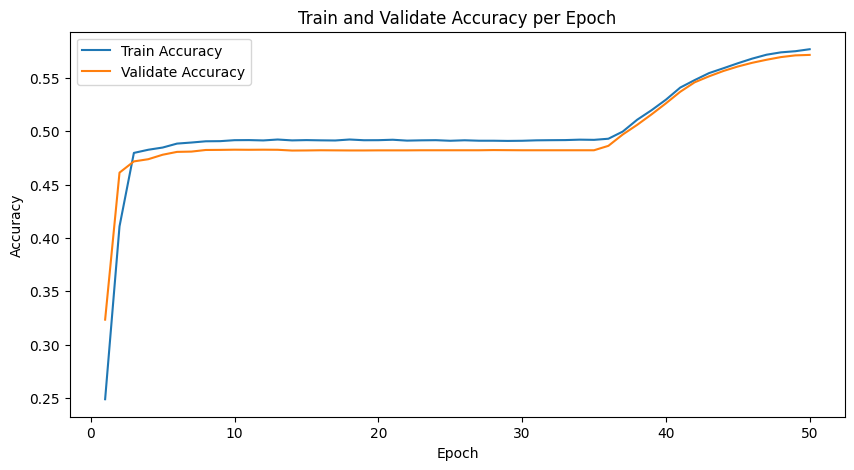

In [16]:
# Set 3

input_dim = x_train.shape[1]
output_dim = len(torch.unique(y_train))

main(input_dim, output_dim, lr=0.0001, batch_size=64, N_epochs=50)

Since my initial parameters was a lr of 0.01, a batch size of 64, and 20 epochs. With this setup, the model was able to learn fairly well but I wanted to test outside the bounds to be able to see what made the model worse vs. better.

Therefore, for my first set, I tried a lr of 0.01, a larger batch size of 128, and 20 epochs. I wanted the model to process more data in each iteration and possibly speed up training. I did not expect the model to maintain as stable as it did, but it learned fairly well. Therefore I believe that a large batch size did not harm my model and it was actually able to converge well with no issues.

For my second set, I wanted to try an aggressive set of learning. My lr was 0.1, my batch size maintained at 120, and my number of epochs 50. I wanted the model to have a faster learning process, but even though the model had a high accuracy rate, it was not stable. Likely due to a higher learning rate whcih made the optimizer unable to settle for a optimal solution. I assume the larger batch size and high learning rate also did not help, as they did not give the model enough time to stabilize with a short number of epochs. This experiment had a lack of fine-tuning.

For the last set, I tried an even more intense model with a learning rate of 0.0001, a batch size of 64, and 50 epochs. Given the extremely slow learning rate, I knew this model would not learn well and it ended up being an accuracy of 0.87. Especially with a small batch size, the model did not have enough time to learn, it limited the amount of data the model processed in each step and slowed down my convergence. The model did not have enough time to make improvements to its learning.


# Q5

In [17]:
# Load the best model
best_model = MyMultiLayerPerception(input_dim, output_dim)
best_model.load_state_dict(torch.load('current_best_model.pth'))

# Set the model to evaluation mode (disables dropout, batch norm, etc.)
best_model.eval()

# Evaluate the model on the test dataset
test_loader = DataLoader(test_dataset, batch_size=120, shuffle=False)

# Disable gradient computation
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0.0
    loss_fun = nn.CrossEntropyLoss()

    for x_batch, y_batch in test_loader:
        # Get predictions
        predictions = best_model(x_batch)

        # Compute loss
        loss = loss_fun(predictions, y_batch)
        test_loss += loss.item()

        # Calculate accuracy
        predicted_labels = torch.argmax(predictions, dim=1)
        correct += (predicted_labels == y_batch).sum().item()
        total += y_batch.size(0)

    # Compute final test accuracy and average loss
    test_accuracy = correct / total
    average_test_loss = test_loss / len(test_loader)

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {average_test_loss:.4f}")


<ipython-input-17-03e1bb4ad5e3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('current_best_model.pth'))


Test Accuracy: 0.5742
Test Loss: 1.3914


Since PyTorch computes graphs during training, the gradients are tracked. When we go into evaluation phase, we don't need to compute gradients. So to prevent PyTorch from building the graphs, we can use `torch.no_grad()`.